In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

from keras.layers import Dropout
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import adam_v2
from sklearn.preprocessing import StandardScaler
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn import preprocessing

In [2]:
turbine1 = pd.read_csv('gas_turbines.csv')
turbine1.head()

AT      AP      AH    AFDP    GTEP     TIT     TAT     TEY     CDP  \
0  6.8594  1007.9  96.799  3.5000  19.663  1059.2  550.00  114.70  10.605   
1  6.7850  1008.4  97.118  3.4998  19.728  1059.3  550.00  114.72  10.598   
2  6.8977  1008.8  95.939  3.4824  19.779  1059.4  549.87  114.71  10.601   
3  7.0569  1009.2  95.249  3.4805  19.792  1059.6  549.99  114.72  10.606   
4  7.3978  1009.7  95.150  3.4976  19.765  1059.7  549.98  114.72  10.612   

       CO     NOX  
0  3.1547  82.722  
1  3.2363  82.776  
2  3.2012  82.468  
3  3.1923  82.670  
4  3.2484  82.311

### cleaning duplicates

In [3]:
turbine = turbine1.drop_duplicates()
turbine.shape

(15039, 11)

In [4]:
turbine.isna().sum()

AT      0
AP      0
AH      0
AFDP    0
GTEP    0
TIT     0
TAT     0
TEY     0
CDP     0
CO      0
NOX     0
dtype: int64

In [5]:
turbine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15039 entries, 0 to 15038
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      15039 non-null  float64
 1   AP      15039 non-null  float64
 2   AH      15039 non-null  float64
 3   AFDP    15039 non-null  float64
 4   GTEP    15039 non-null  float64
 5   TIT     15039 non-null  float64
 6   TAT     15039 non-null  float64
 7   TEY     15039 non-null  float64
 8   CDP     15039 non-null  float64
 9   CO      15039 non-null  float64
 10  NOX     15039 non-null  float64
dtypes: float64(11)
memory usage: 1.4 MB


In [6]:
turbine.describe()

AT           AP            AH          AFDP          GTEP  \
count  15039.000000  15039.00000  15039.000000  15039.000000  15039.000000   
mean      17.764381   1013.19924     79.124174      4.200294     25.419061   
std        7.574323      6.41076     13.793439      0.760197      4.173916   
min        0.522300    985.85000     30.344000      2.087400     17.878000   
25%       11.408000   1008.90000     69.750000      3.723900     23.294000   
50%       18.186000   1012.80000     82.266000      4.186200     25.082000   
75%       23.862500   1016.90000     90.043500      4.550900     27.184000   
max       34.929000   1034.20000    100.200000      7.610600     37.402000   

                TIT           TAT           TEY           CDP            CO  \
count  15039.000000  15039.000000  15039.000000  15039.000000  15039.000000   
mean    1083.798770    545.396183    134.188464     12.102353      1.972499   
std       16.527806      7.866803     15.829717      1.103196      2.222206   
min     1000.800000    512.450000    100.170000      9.904400      0.000388   
25%     1079.600000    542.170000    127.985000     11.622000      0.858055   
50%     1088.700000    549.890000    133.780000     12.025000      1.390200   
75%     1096.000000    550.060000    140.895000     12.578000      2.160400   
max     1100.800000    550.610000    174.610000     15.081000     44.103000   

                NOX  
count  15039.000000  
mean      68.190934  
std       10.470586  
min       27.765000  
25%       61.303500  
50%       66.601000  
75%       73.935500  
max      119.890000

### Visualization

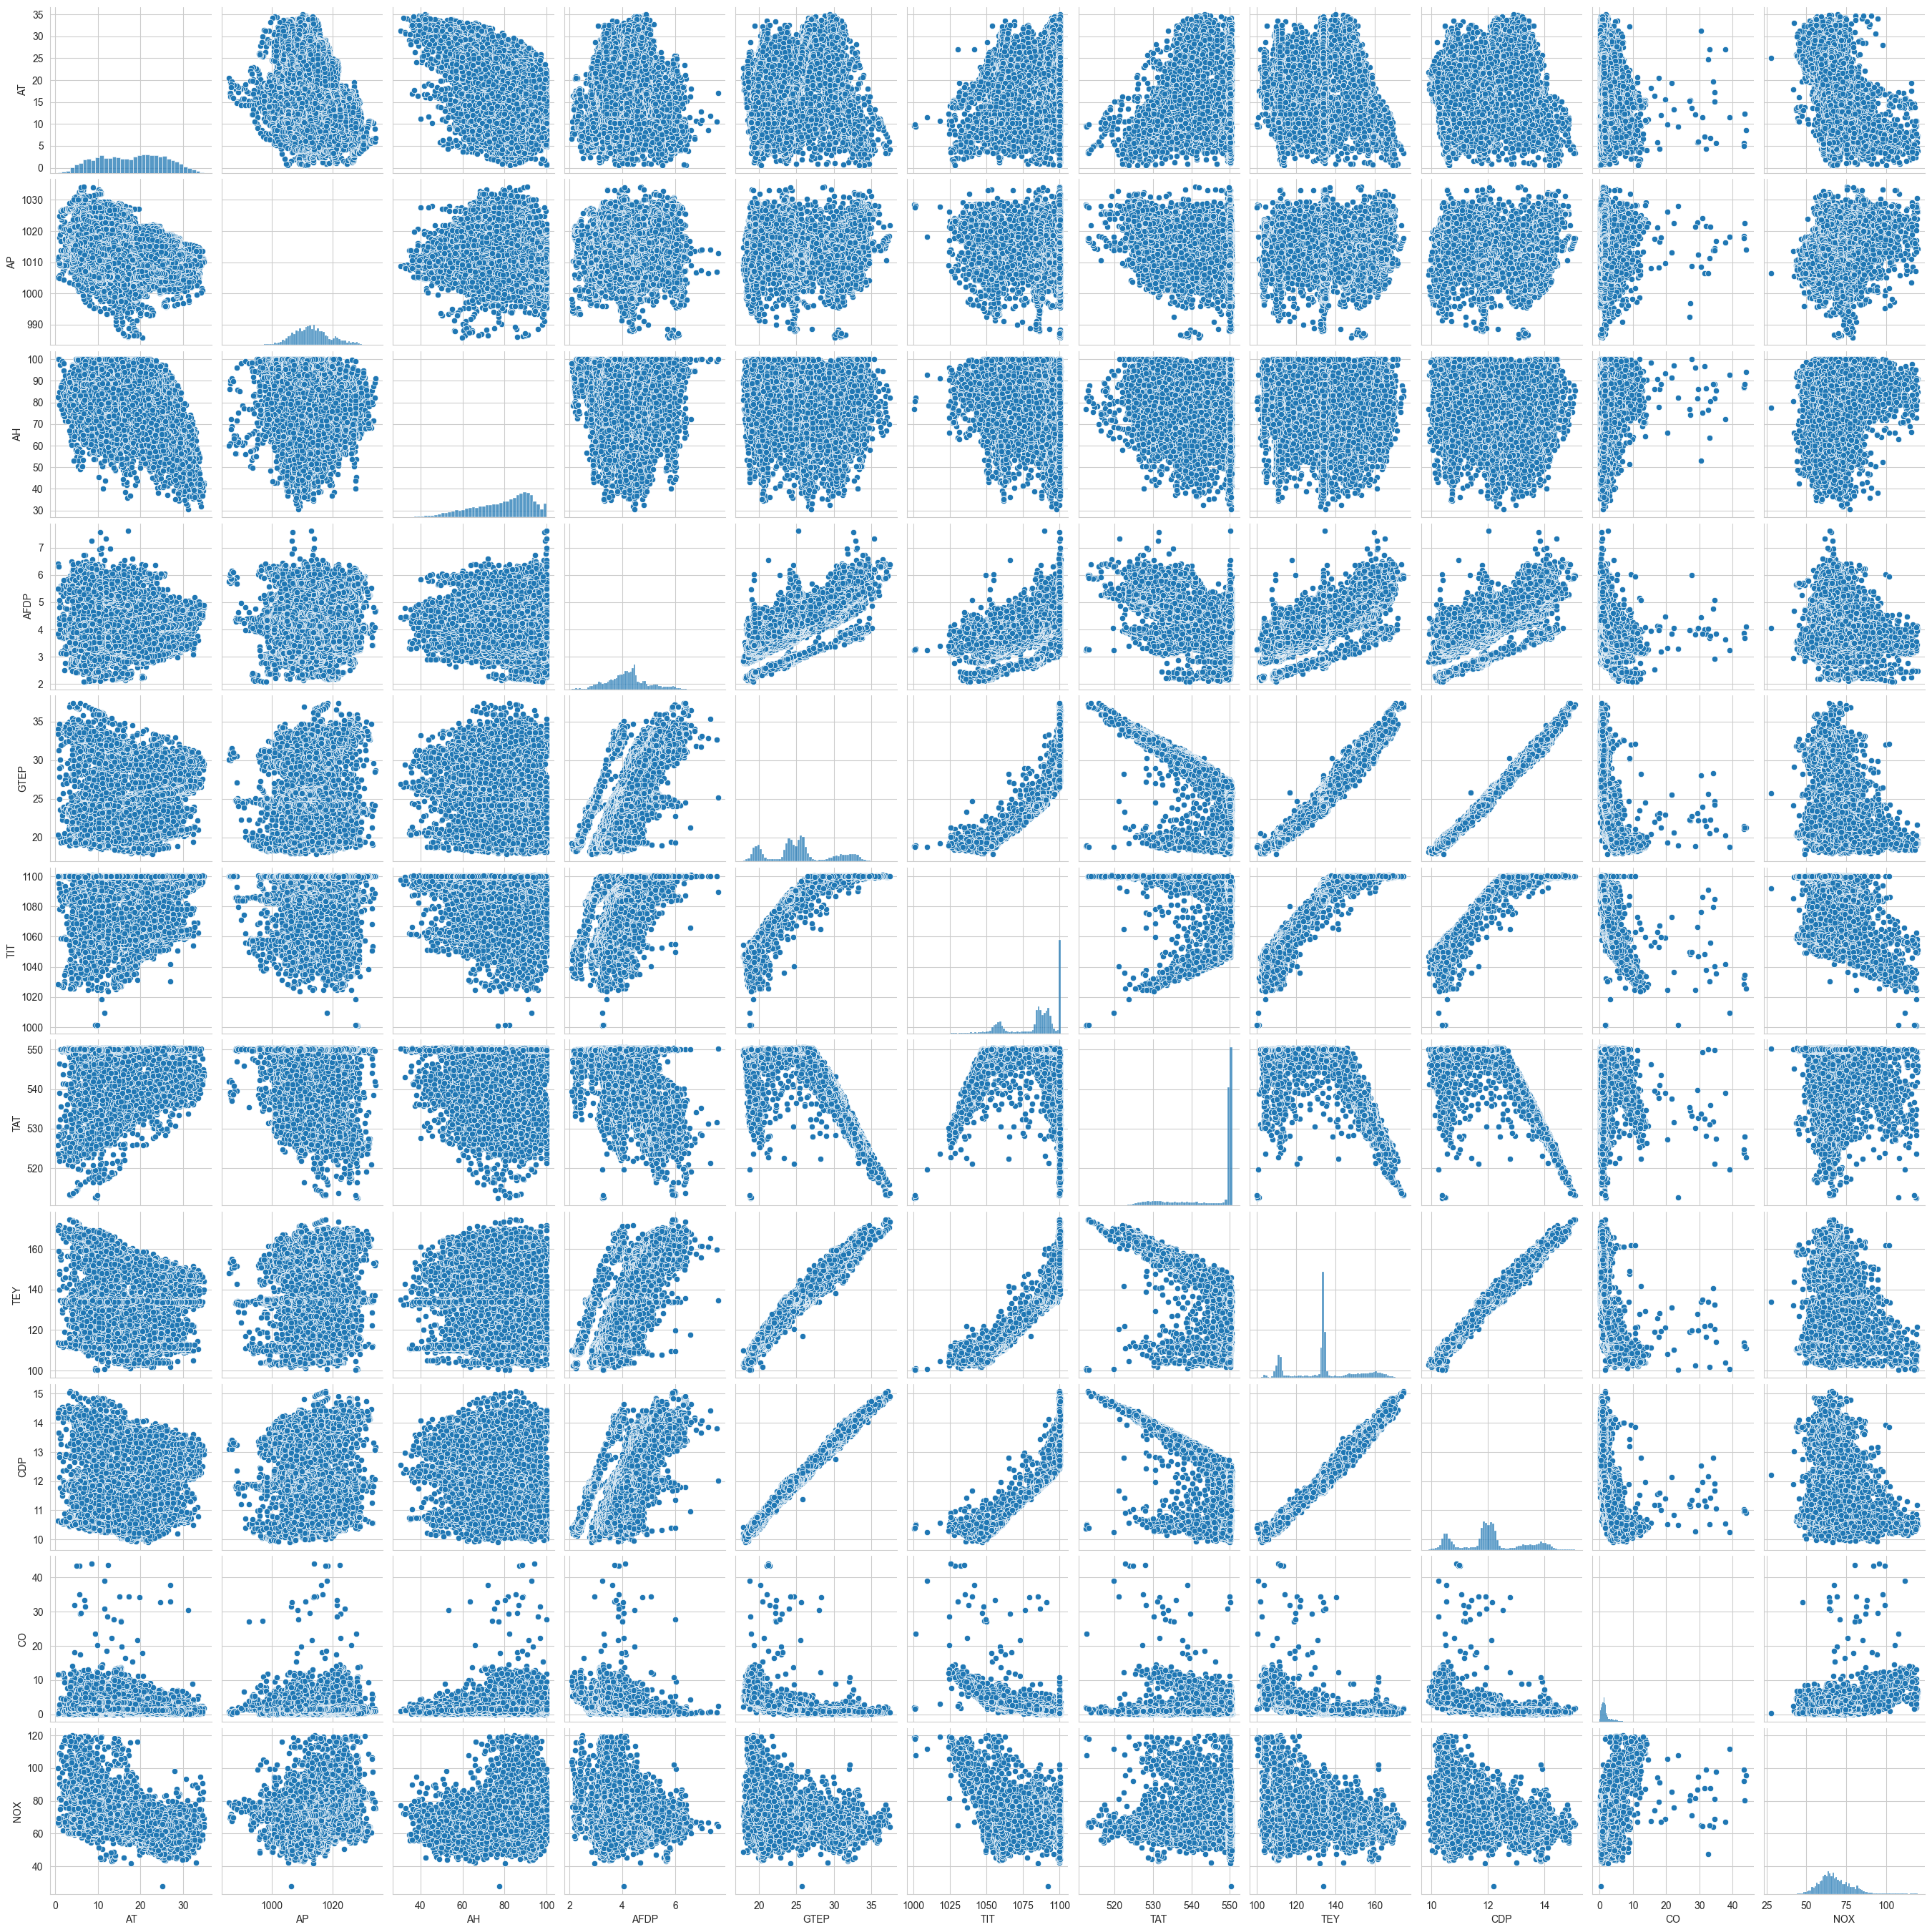

In [7]:
sns.pairplot(turbine)
plt.show()

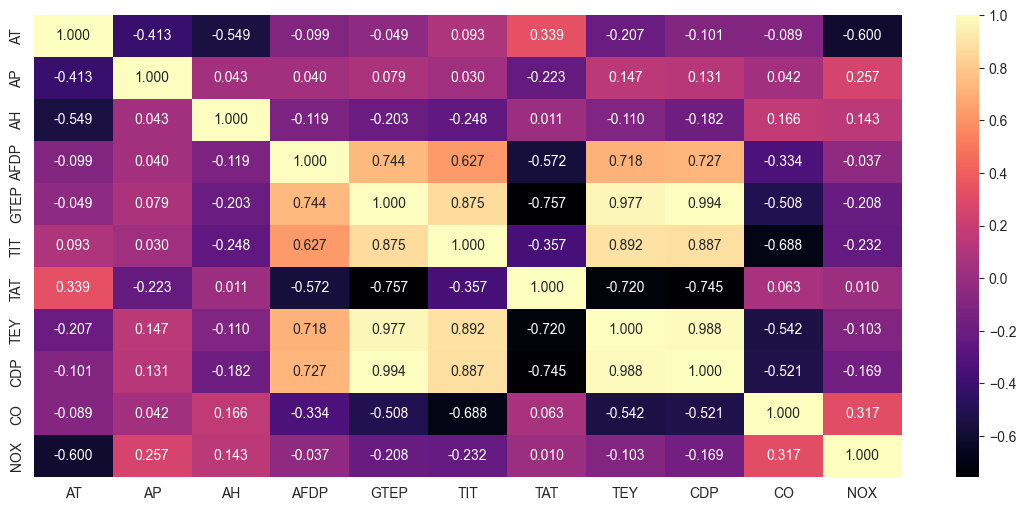

In [8]:
plt.figure(figsize = (14, 6));
sns.heatmap(turbine.corr(), cmap='magma', annot=True, fmt=".3f")
plt.show()

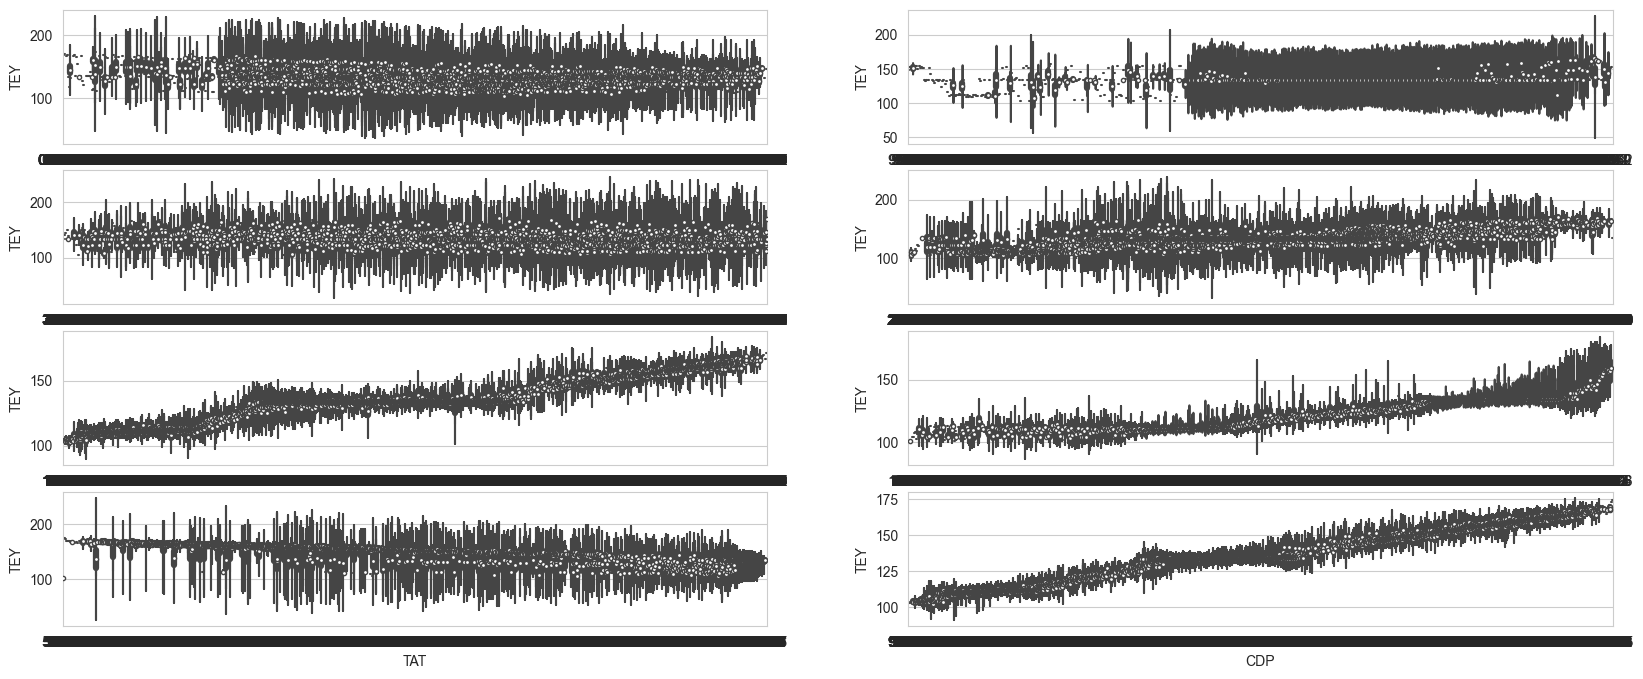

In [9]:
f, axes = plt.subplots(4, 2, figsize=(20,8))
sns.violinplot(x = 'AT', y = 'TEY', data = turbine, scatter_kws={'alpha':0.6}, ax = axes[0,0])
sns.violinplot(x = 'AP', y = 'TEY', data = turbine, scatter_kws={'alpha':0.6}, ax = axes[0,1])
sns.violinplot(x = 'AH', y = 'TEY', data = turbine, scatter_kws={'alpha':0.6}, ax = axes[1,0])
sns.violinplot(x = 'AFDP', y = 'TEY', data = turbine, scatter_kws={'alpha':0.6}, ax = axes[1,1])

sns.violinplot(x = 'GTEP', y = 'TEY', data = turbine, scatter_kws={'alpha':0.6}, ax = axes[2,0])
sns.violinplot(x = 'TIT', y = 'TEY', data = turbine, scatter_kws={'alpha':0.6}, ax = axes[2,1])
sns.violinplot(x = 'TAT', y = 'TEY', data = turbine, scatter_kws={'alpha':0.6}, ax = axes[3,0])
sns.violinplot(x = 'CDP', y = 'TEY', data = turbine, scatter_kws={'alpha':0.6}, ax = axes[3,1])
plt.show()

## Build Neural Network

In [10]:
np.random.seed(8)

# split into input (X) and output (Y) variables
X = turbine.drop(['TEY'],axis=1)
Y = turbine['TEY']
X

AT      AP      AH    AFDP    GTEP     TIT     TAT     CDP      CO  \
0      6.8594  1007.9  96.799  3.5000  19.663  1059.2  550.00  10.605  3.1547   
1      6.7850  1008.4  97.118  3.4998  19.728  1059.3  550.00  10.598  3.2363   
2      6.8977  1008.8  95.939  3.4824  19.779  1059.4  549.87  10.601  3.2012   
3      7.0569  1009.2  95.249  3.4805  19.792  1059.6  549.99  10.606  3.1923   
4      7.3978  1009.7  95.150  3.4976  19.765  1059.7  549.98  10.612  3.2484   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
15034  9.0301  1005.6  98.460  3.5421  19.164  1049.7  546.21  10.400  4.5186   
15035  7.8879  1005.9  99.093  3.5059  19.414  1046.3  543.22  10.433  4.8470   
15036  7.2647  1006.3  99.496  3.4770  19.530  1037.7  537.32  10.483  7.9632   
15037  7.0060  1006.8  99.008  3.4486  19.377  1043.2  541.24  10.533  6.2494   
15038  6.9279  1007.2  97.533  3.4275  19.306  1049.9  545.85  10.583  4.9816   

          NOX  
0      82.722  
1      82.776  
2      82.468  
3      82.670  
4      82.311  
...       ...  
15034  79.559  
15035  79.917  
15036  90.912  
15037  93.227  
15038  92.498  

[15039 rows x 10 columns]

In [11]:
Y

0        114.70
1        114.72
2        114.71
3        114.72
4        114.72
          ...  
15034    111.61
15035    111.78
15036    110.19
15037    110.74
15038    111.58
Name: TEY, Length: 15039, dtype: float64

### 1. Batch Size and Epochs

In [12]:
# create model
model = Sequential()
model.add(Dense(26, input_dim = 10,  activation='relu')) #1st layer
model.add(Dense(26,  activation='tanh')) #2nd layer
model.add(Dense(26, activation='sigmoid')) #3rd layer 
model.add(Dense(26, activation='leaky_relu')) #4th layer or op layer

In [13]:
# Compile model
model.compile(loss='mse', optimizer='adam', metrics=['mean_absolute_percentage_error'])

In [14]:
# Fit the model
history = model.fit(X, Y, validation_split=0.33, epochs=20, batch_size=10)

Epoch 1/20
1008/1008 [==============================] - 3s 2ms/step - loss: 14904.7910 - mean_absolute_percentage_error: 89.0880 - val_loss: 11013.0645 - val_mean_absolute_percentage_error: 78.3969
Epoch 2/20
1008/1008 [==============================] - 2s 2ms/step - loss: 9327.6211 - mean_absolute_percentage_error: 69.8032 - val_loss: 6610.3765 - val_mean_absolute_percentage_error: 59.9842
Epoch 3/20
1008/1008 [==============================] - 2s 2ms/step - loss: 5508.4658 - mean_absolute_percentage_error: 52.7124 - val_loss: 3618.9038 - val_mean_absolute_percentage_error: 43.3380
Epoch 4/20
1008/1008 [==============================] - 2s 2ms/step - loss: 2952.7109 - mean_absolute_percentage_error: 37.3097 - val_loss: 1733.9310 - val_mean_absolute_percentage_error: 28.4013
Epoch 5/20
1008/1008 [==============================] - 2s 2ms/step - loss: 1402.1182 - mean_absolute_percentage_error: 23.7122 - val_loss: 719.6271 - val_mean_absolute_percentage_error: 15.9039
Epoch 6/20
1008/100

In [15]:
# evaluate the model
scores = model.evaluate(X, Y)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]))

470/470 [==============================] - 1s 1ms/step - loss: 251.8501 - mean_absolute_percentage_error: 8.8823
mean_absolute_percentage_error: 8.88%


In [16]:
model.metrics_names

['loss', 'mean_absolute_percentage_error']

In [17]:
scores

[251.8501434326172, 8.882320404052734]

In [18]:
# Visualize training history

# list all data in history
history.history.keys()

dict_keys(['loss', 'mean_absolute_percentage_error', 'val_loss', 'val_mean_absolute_percentage_error'])

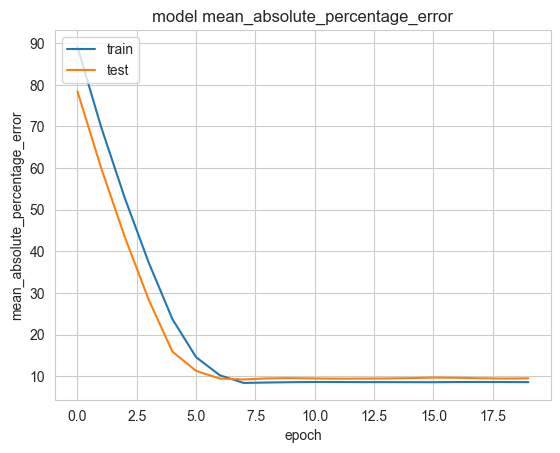

In [19]:
# summarize history for accuracy
plt.plot(history.history['mean_absolute_percentage_error'])
plt.plot(history.history['val_mean_absolute_percentage_error'])
plt.title('model mean_absolute_percentage_error')
plt.ylabel('mean_absolute_percentage_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

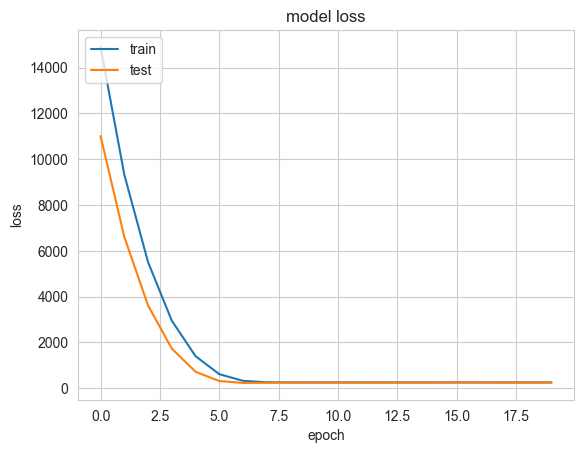

In [20]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Hyperparameters all at once


The hyperparameter optimization was carried out by taking 2 hyperparameters at once. We may have missed the best values. The performance can be further improved by finding the optimum values of hyperparameters all at once given by the code snippet below.
#### This process is computationally expensive.